In [116]:
from slda.topic_models import SLDA
from functools import partial
from sklearn.metrics import (mean_squared_error)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import fnmatch
import re
import random
from scipy import sparse

def vectorize(df):
    nFeatures=1000
    tf_vectorizer = CountVectorizer(max_df=0.85, min_df=0.2,
                                max_features=nFeatures,
                                stop_words='english', lowercase=True)
    tf = tf_vectorizer.fit_transform(df)
    features = tf_vectorizer.get_feature_names()
    return (tf, features)

def sldaPred(model, wordMat, n_iter, d, n_samples):
#     burn_in = max(n_iter - 100, int(n_iter / 2))
#     print(np.shape(model.loglikelihoods), np.shape(model.eta))
    lglk=model.loglikelihoods[n_samples:].mean()
    eta_pred = model.eta[n_samples:].mean(axis=0)

    thetas_test_slda = model.transform(wordMat)
    y_slda = [np.dot(eta_pred, thetas_test_slda[i]) for i in range(d)]
    return (y_slda, lglk)

def runSLDA(df, wordMat, features):
#     wordMat, features=vectorize(df['Review'])
    scr=df['GameSpotScore']
    scr=list(scr)
    scr=np.array(scr)

    K=25
    D=len(df)
    V=len(features)
    nu2 = 10
    sigma2 = 1

    alpha = np.ones(K)
    np.random.seed(42)
    thetas = np.random.dirichlet(alpha, size=D)
    np.random.seed(42)
    eta = np.random.normal(scale=nu2, size=K)


    _K = K
    _alpha = alpha
    _beta = np.repeat(0.01, V)
    _mu = 0
    _nu2 = nu2
    _sigma2 = sigma2
    n_iter = 500
    slda = SLDA(_K, _alpha, _beta, _mu, _nu2, _sigma2, n_iter)
    slda.fit(wordMat, scr)
    
    res={}
    res['model']=slda
    res['wordMat']=wordMat
    res['features']=features
    return res

def subWordMatrix(wordMat, indices):
    subWordMat=np.empty((0, np.shape(wordMat)[1]))
    for index in indices:
        vec=wordMat[index]
        subWordMat=np.append(subWordMat, vec, axis=0)
    return subWordMat

def calcRMSE(A,B):
    sse=0
    n=len(A)
    for a, b in zip(A, B):
        sse+=(a-b)**2
    rmse=(sse/n)**2
    return rmse

In [117]:
df=pd.DataFrame(columns=['Name', 'Publisher', 'GameSpotScore', 'Review', 'Console', 'Genre'])

i=0
for dirpath, dirs, files in os.walk('dataset/reviews'):   
    for file in fnmatch.filter(files, '*.txt'):
        with open(os.path.join(dirpath, file), 'r') as ip:
            data=ip.read()
            name=re.findall(r':::Game Name:::(.*?)-----', data, re.DOTALL)[0].strip()
            review=re.findall(r':::Review:::(.*?)-----',data, re.DOTALL)[0].strip()
            scores=re.findall(r':::Scores:::(.*?)-----',data, re.DOTALL)[0]
            addition=re.findall(r':::Addition:::(.*?)-----',data, re.DOTALL)[0]
            gsScore=re.findall(r'GameSpot Score:(.*?)\n', scores)[0]
            try:
                pub=re.findall(r'Publisher:(.*?)\n', addition)[0]
            except:
                pub=''
            try:
                genre=re.findall(r'Genre:(.*?)\n', addition)[0]
            except:
                genre=''
            console=dirpath.strip('dataset/reviews/')
            df.loc[i]=[name, pub, gsScore, review, console, genre]
            i+=1

In [118]:
df['GameSpotScore'] =pd.to_numeric(df['GameSpotScore'])
wordMat, features=vectorize(df['Review'])
slda=runSLDA(df, wordMat, features)

2017-04-15 12:19:41.536384 start iterations
2017-04-15 12:19:55.034724 0:00:13.498340 elapsed, iter   10, LL -2554196.4370, 17.24% change from last
2017-04-15 12:20:07.990099 0:00:26.453715 elapsed, iter   20, LL -2066951.3107, 19.08% change from last
2017-04-15 12:20:20.786400 0:00:39.250016 elapsed, iter   30, LL -1852633.2938, 10.37% change from last
2017-04-15 12:20:33.433866 0:00:51.897482 elapsed, iter   40, LL -1741697.5159, 5.99% change from last
2017-04-15 12:20:46.009293 0:01:04.472909 elapsed, iter   50, LL -1674358.3428, 3.87% change from last
2017-04-15 12:20:58.473674 0:01:16.937290 elapsed, iter   60, LL -1627997.1546, 2.77% change from last
2017-04-15 12:21:10.962993 0:01:29.426609 elapsed, iter   70, LL -1598275.8258, 1.83% change from last
2017-04-15 12:21:23.410263 0:01:41.873879 elapsed, iter   80, LL -1579830.8935, 1.15% change from last
2017-04-15 12:21:36.063781 0:01:54.527397 elapsed, iter   90, LL -1559861.8499, 1.26% change from last
2017-04-15 12:21:48.551490

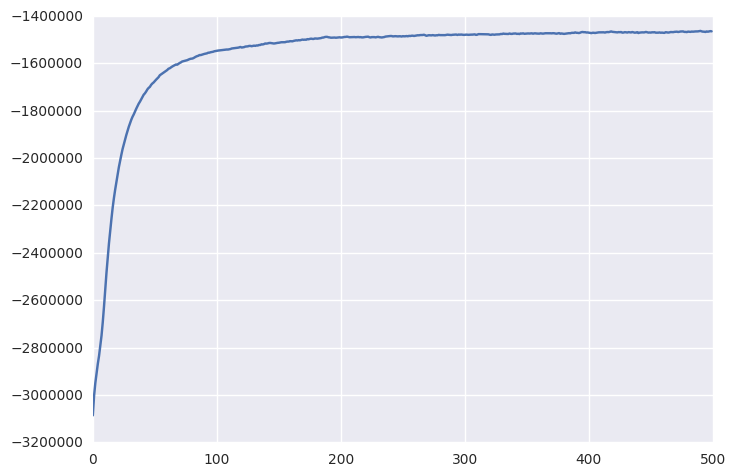

In [119]:
plt.plot(slda['model'].loglikelihoods)

In [120]:
game1=df[(df['Console']=='DS')].ix[np.random.choice(df[(df['Console']=='DS')].index, 1)]
game2=df[(df['Console']=='ps3')].ix[np.random.choice(df[(df['Console']=='ps3')].index, 1)]
game3=df[(df['Console']=='Xbox360')].ix[np.random.choice(df[(df['Console']=='Xbox360')].index, 1)]

wordMat1=wordMat[game1.index.get_values()[0]]
wordMat2=wordMat[game2.index.get_values()[0]]
wordMat3=wordMat[game3.index.get_values()[0]]


y1=sldaPred(slda['model'], wordMat1, 200, 1,490)
y2=sldaPred(slda['model'], wordMat2, 200, 1,490)
y3=sldaPred(slda['model'], wordMat3, 200, 1,490)

print(game1['Name'].values[0], 'Original Rating:',game1['GameSpotScore'].values[0], 'Predicted Rating:', y1[0])
print(game2['Name'].values[0], 'Original Rating:',game2['GameSpotScore'].values[0], 'Predicted Rating:', y2[0])
print(game3['Name'].values[0], 'Original Rating:',game3['GameSpotScore'].values[0], 'Predicted Rating:', y3[0])

Resident Evil: Deadly Silence Original Rating: 7.9 Predicted Rating: [6.8696331859960136]
Ninja Gaiden Sigma Original Rating: 9.0 Predicted Rating: [7.1622874623864474]
Beowulf Original Rating: 5.0 Predicted Rating: [4.559021106292696]


In [121]:
n=len(df)
wordMat, features=vectorize(df['Review'])
n_train=int(n*0.9)
n_test=n-n_train

wordMat=wordMat.todense()
testRows=random.sample((list(df.index)), n_test)
test_df=df.ix[testRows]
train_df=df.drop(testRows)

subWordMatTest=subWordMatrix(wordMat, test_df.index)
subWordMatTest=sparse.csr_matrix(subWordMatTest, dtype='int')
print(type (subWordMatTest))
subWordMatTrain=subWordMatrix(wordMat, train_df.index)
subWordMatTrain=sparse.csr_matrix(subWordMatTrain, dtype='int')

train_slda=runSLDA(train_df, subWordMatTrain, features)

<class 'scipy.sparse.csr.csr_matrix'>
2017-04-15 12:36:48.471636 start iterations
2017-04-15 12:37:00.959952 0:00:12.488316 elapsed, iter   10, LL -2277219.7074, 18.18% change from last
2017-04-15 12:37:12.308460 0:00:23.836824 elapsed, iter   20, LL -1828060.9381, 19.72% change from last
2017-04-15 12:37:23.575671 0:00:35.104035 elapsed, iter   30, LL -1651104.2202, 9.68% change from last
2017-04-15 12:37:34.926034 0:00:46.454398 elapsed, iter   40, LL -1558061.7548, 5.64% change from last
2017-04-15 12:37:46.406719 0:00:57.935083 elapsed, iter   50, LL -1497962.1628, 3.86% change from last
2017-04-15 12:37:57.855667 0:01:09.384031 elapsed, iter   60, LL -1458479.0458, 2.64% change from last
2017-04-15 12:38:09.253855 0:01:20.782219 elapsed, iter   70, LL -1431382.3532, 1.86% change from last
2017-04-15 12:38:20.669020 0:01:32.197384 elapsed, iter   80, LL -1412327.0278, 1.33% change from last
2017-04-15 12:38:32.227046 0:01:43.755410 elapsed, iter   90, LL -1398288.1396, 0.99% change

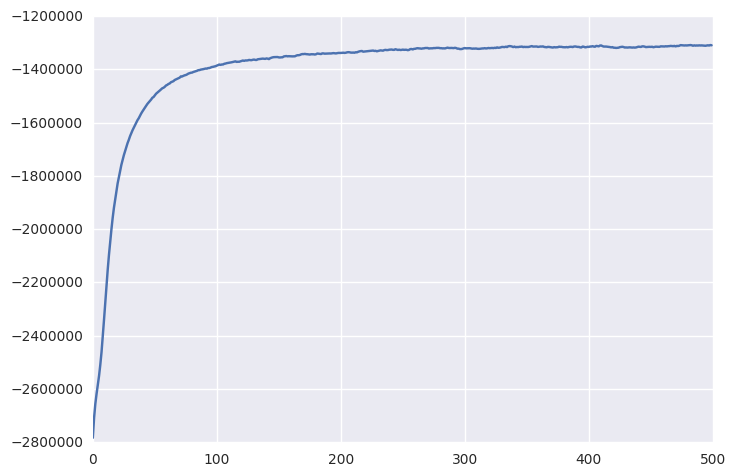

In [122]:
y, lglk=sldaPred(train_slda['model'], subWordMatTest, 200, len(test_df), 1)
plt.plot(train_slda['model'].loglikelihoods)

In [123]:
rmse=calcRMSE(test_df['GameSpotScore'], y)
print(rmse)

3.03233545906


(431,) (431,)


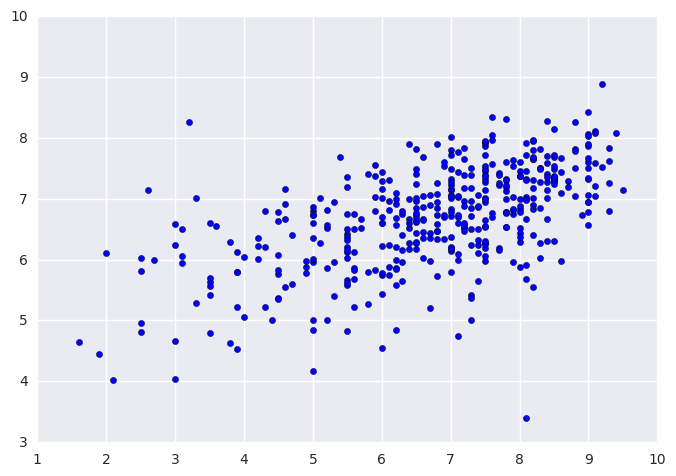

In [124]:
x_val=test_df['GameSpotScore']
y_val=y
print(np.shape(x_val), np.shape(y_val))
plt.scatter(x_val, y_val)
plt.show()

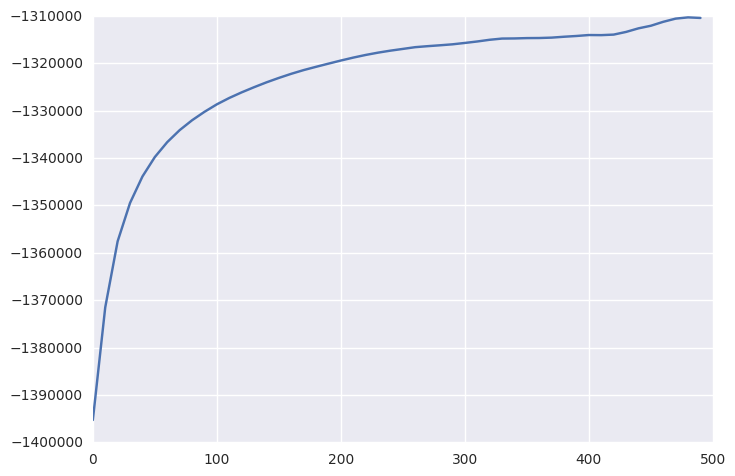

In [125]:
i=0
samples=[]
lglk_=[]
while(i<500):
    samples.append(i)
    i=i+10
for val in samples:
    y, lglk=sldaPred(train_slda['model'], subWordMatTest, 200, len(test_df), val)
    lglk_.append(lglk)
plt.plot(samples, lglk_)